In [1]:
import numpy as np

from matplotlib import pyplot as plt
from time import time
from tqdm import tqdm
from scipy.sparse import csr_matrix, csc_matrix
from numba import jit

%matplotlib inline

In [2]:
start = 0
stop = 400

In [11]:
@jit
def image_for_src_snk(d, X, Y, start, stop, dr, x_src, y_src, x_snk, y_snk, ref):
    """
        measured data, Xgrid, Ygrid, start_idx, stop_idx, step_distance, x_src, y_src, x_snk, y_snk, image
    """
    #ts = time()
    
    # Distance field regarind source and sink
    R_src = np.sqrt((X - x_src)**2 + (Y - y_src)**2)
    R_snk = np.sqrt((X - x_snk)**2 + (Y - y_snk)**2)

    R_tot = R_src + R_snk

    Mt = np.zeros((ref.shape[0]*ref.shape[1], stop-start))

    for i in range(start, stop):
        ff = np.ravel( ((R_src + R_snk) < (i+1)*dr) * ((R_src + R_snk) > i*dr))
        rsq = np.ravel((R_src + R_snk)**2)

        # Mt computes the approx. inverse
        Mt[:, i-start] = rsq*ff
    
    #Mt = csr_matrix(Mt)
    r = np.dot(Mt, d).reshape(ref.shape)
    #r = Mt.dot(d).reshape(r.shape)
    
    #print(time()-ts)
    
    return r

@jit
def fwd_for_src_snk(X, Y, start, stop, dr, x_src, y_src, x_snk, y_snk, r):

    #ts = time()
    
    R_src = np.sqrt((X - x_src)**2 + (Y - y_src)**2)
    R_snk = np.sqrt((X - x_snk)**2 + (Y - y_snk)**2)

    M = np.zeros((stop-start, nx*ny))

    for i in range(start, stop):
        ff = (((R_src + R_snk) < (i+1)*dr) * ((R_src + R_snk) > i*dr)).ravel()
        rsq = ((R_src + R_snk)**2).ravel()

        # Mt computes the approx. inverse
        M[i-start,:] = 1./rsq*ff
    
    y = np.dot(M, r.ravel())
    
    #print(time()-ts)
    
    return y

In [12]:
nx = 201
ny = 201
x = np.linspace(-0.2, 0.2, nx)
y = np.linspace(0.1, 0.5, ny)
X, Y = np.meshgrid(x, y)

X_src, Y_src = np.meshgrid(np.linspace(-0.5, 0.5, 9), np.zeros(1))
X_snk, Y_snk = np.meshgrid(np.linspace(-0.5, 0.5, 9) + 0.05, np.zeros(1))
x_src = X_src.ravel()
y_src = Y_src.ravel()
x_snk = X_snk.ravel()
y_snk = Y_snk.ravel()

srcs = [(x, y_src[k]) for k, x in enumerate(x_src)]
snks = [(x, y_snk[k]) for k, x in enumerate(x_snk)]

###### FWD Modell
ri = np.zeros((nx,ny))
r = np.zeros((nx,ny))
r[25,20] = 1.*10
r[70,80] = 2.*10
r[40,10] = 1.5*10
r[10,50] = 1.1*10

xt = np.linspace(0,nx)
yt = np.round(20*(np.sin(0.08*xt)+1)+30)

for i in range(nx):
    r[int(np.round(20*(np.sin(0.08*i)+1)+30)), i] = 0.01*np.sin(0.07*i)+1.
#####
    
dr = 0.005

ys = np.zeros((len(snks)*len(srcs), stop-start))
c = 0

# FWD
for src in tqdm(srcs):
    for snk in snks:
        y = fwd_for_src_snk(X, Y, start, stop, dr, src[0], src[1], snk[0], snk[1], r) + 10*np.random.randn(400) # 3-6dB SNR
        ys[c,:] = y
        #rii = image_for_src_snk(y, X, Y, start, stop, dr, src[0], src[1], snk[0], snk[1], r)
        #rii = rii/np.max(rii) #linalg.norm?
        #ri += rii
        c += 1
        #ri /= np.linalg.norm(ri)

c = 0
# Multi-offset 
for src in tqdm(srcs):
    for snk in snks:
        #y = fwd_for_src_snk(X, Y, start, stop, dr, src[0], src[1], snk[0], snk[1], r) #+ np.random.randn(400) # 3-6dB SNR
        #ys[c,:] = y
        rii = image_for_src_snk(ys[c,:], X, Y, start, stop, dr, src[0], src[1], snk[0], snk[1], r)
        rii = rii/np.max(rii) #linalg.norm?
        ri += rii
        c += 1
        #ri /= np.linalg.norm(ri)
        
# Zero-offset
#for src in tqdm(srcs):
#    y = fwd_for_src_snk(X, Y, start, stop, dr, src[0], src[1], src[0], src[1], r) #+ np.random.randn(400) # 3-6dB SNR
#    ys[c,:] = y
#    rii = image_for_src_snk(y, X, Y, start, stop, dr, src[0], src[1], src[0], src[1], r)
#    rii = rii/np.max(rii) #linalg.norm?
#    ri += rii
#    c += 1
#    #ri /= np.linalg.norm(ri)

100%|██████████| 9/9 [00:25<00:00,  2.78s/it]


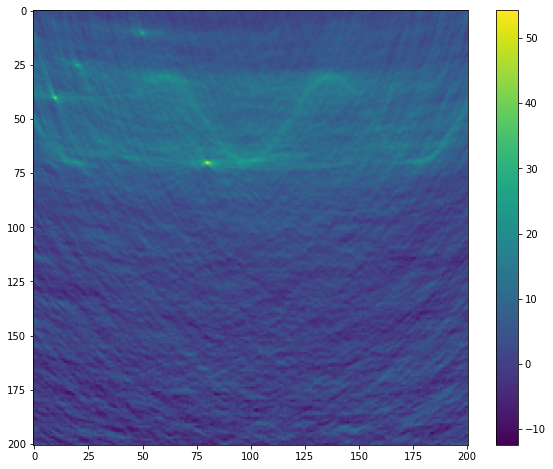

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches((10,8))
p = ax.imshow(ri)#,vmax=0.5)#, vmin=0.98,vmax=1.01, interpolation='None')#, vmin=0.1)
plt.colorbar(p)

In [14]:
whos

Variable            Type                          Data/Info
-----------------------------------------------------------
X                   ndarray                       201x201: 40401 elems, type `float64`, 323208 bytes (315.6328125 kb)
X_snk               ndarray                       1x9: 9 elems, type `float64`, 72 bytes
X_src               ndarray                       1x9: 9 elems, type `float64`, 72 bytes
Y                   ndarray                       201x201: 40401 elems, type `float64`, 323208 bytes (315.6328125 kb)
Y_snk               ndarray                       1x9: 9 elems, type `float64`, 72 bytes
Y_src               ndarray                       1x9: 9 elems, type `float64`, 72 bytes
ax                  AxesSubplot                   AxesSubplot(0.141,0.125;0.604x0.755)
c                   int                           81
csc_matrix          type                          <class 'scipy.sparse.csc.csc_matrix'>
csr_matrix          type                          <class 'sc